In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('../Data/archive/online_retail_II.csv')
df.head() 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [70]:
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [71]:
df.columns = ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'CustomerID', 'Country']

In [72]:
# Check for missing values
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
CustomerID     243007
Country             0
dtype: int64

In [73]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

In [74]:
# Drop rows with missing Description (optional)
df = df.dropna(subset=['Description'])

In [75]:
# Remove canceled orders (Invoice starts with 'C')
df = df[~df['Invoice'].str.startswith('C')]
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [76]:
# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [77]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

In [78]:
# Check for duplicates
print("Duplicates:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

Duplicates: 26124


In [79]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [80]:
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notnull()]

# Remove canceled orders (Invoice starts with 'C')
df = df[~df['Invoice'].str.startswith('C')]

# Remove rows with non-positive Quantity or Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

In [81]:
# Create a new column for Total Price
df['TotalPrice'] = df['Quantity'] * df['Price']

In [82]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Set reference date as one day after the last invoice date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print(reference_date)

2011-12-10 12:50:00


In [83]:
# Create RFM Table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',  # Frequency (number of invoices)
    'Price': 'sum'  # Monetary (total spent)
})

# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Price': 'Monetary'
}, inplace=True)

rfm = rfm.reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,207.40
1,12347.0,2,8,554.57
2,12348.0,75,5,193.10
3,12349.0,19,4,1480.44
4,12350.0,310,1,65.30


In [84]:
# Drop duplicate values from Frequency
rfm['Frequency'] = rfm['Frequency'].drop_duplicates()

# Now apply the qcut function
rfm['Recency_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['Frequency_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine the scores to create a total RFM score
rfm['RFM_Score'] = rfm['Recency_Score'].astype(str) + rfm['Frequency_Score'].astype(str) + rfm['Monetary_Score'].astype(str)

# View the first few rows
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
0,12346.0,326,12.0,207.40,2,1,3,213
1,12347.0,2,8.0,554.57,5,1,5,515
2,12348.0,75,5.0,193.10,3,1,3,313
3,12349.0,19,4.0,1480.44,5,1,5,515
4,12350.0,310,1.0,65.30,2,1,2,212


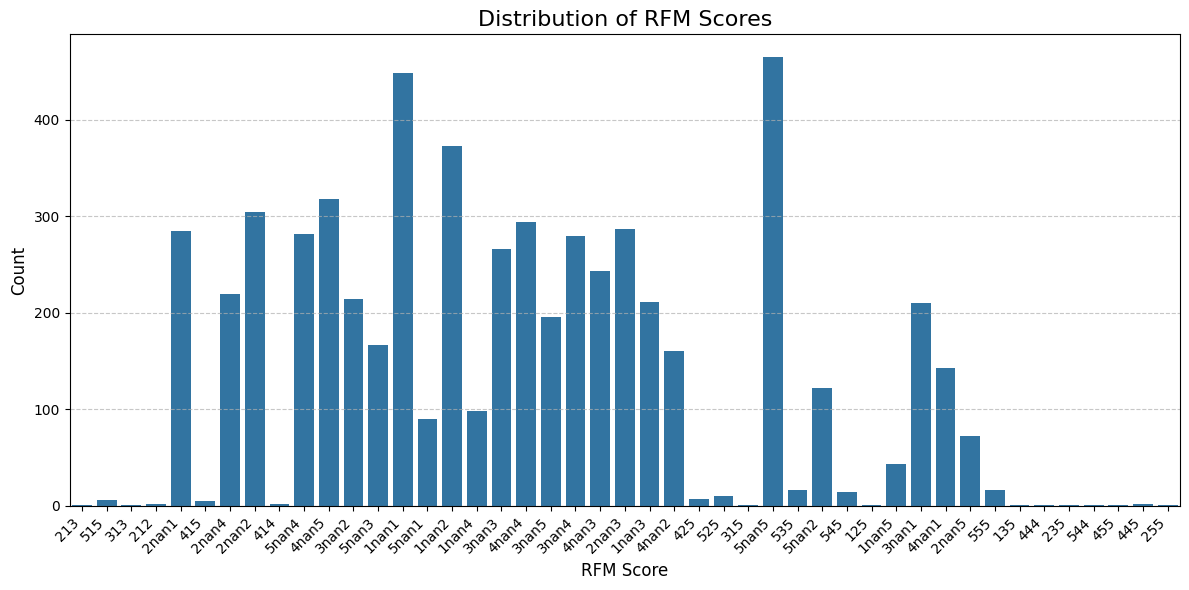

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of RFM Scores with more adjustments
plt.figure(figsize=(12, 6))  # Larger figure size
sns.countplot(x='RFM_Score', data=rfm)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust rotation and font size

# Adjust y-axis labels
plt.yticks(fontsize=10)

# Add title and labels with larger font size
plt.title('Distribution of RFM Scores', fontsize=16)
plt.xlabel('RFM Score', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add gridlines for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()  # Ensure no overlapping elements
plt.show()


In [86]:
from sklearn.model_selection import train_test_split

# Assuming your features are 'Recency', 'Frequency', 'Monetary' and RFM Scores
X = rfm[['Recency', 'Frequency', 'Monetary']]  # or use the RFM scores as well
y = rfm['Monetary']  # Target is monetary value or a calculated CLTV value

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 4.575065051020399
Mean Squared Error: 11987.591147824221
R-squared: 0.9880784678032578


In [89]:
from sklearn.model_selection import train_test_split

# Features and Target
X = rfm[['Recency', 'Frequency', 'Monetary']]  # You can also try with RFM_Scores later
y = rfm['Monetary']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Absolute Error: 4.58
Mean Squared Error: 11987.59
Root Mean Squared Error: 109.49
R-squared: 0.99


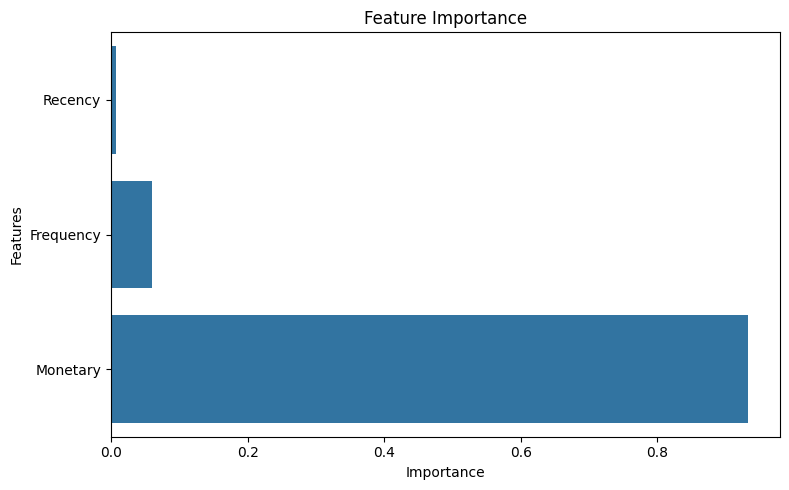

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance plot
importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [93]:
import joblib

# Save the model
joblib.dump(model, 'cltv_random_forest_model.pkl')

['cltv_random_forest_model.pkl']

In [94]:
# Step 1: Create additional features for CLTV
rfm['AverageOrderValue'] = rfm['Monetary'] / rfm['Frequency']
total_customers = rfm.shape[0]
repeat_rate = rfm[rfm['Frequency'] > 1].shape[0] / total_customers
rfm['PurchaseFrequency'] = rfm['Frequency'] / total_customers
rfm['CustomerValue'] = rfm['AverageOrderValue'] * rfm['PurchaseFrequency']
rfm['CLTV'] = rfm['CustomerValue'] * repeat_rate
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,AverageOrderValue,PurchaseFrequency,CustomerValue,CLTV
0,12346.0,326,12.0,207.40,2,1,3,213,17.283333,0.002042,0.035284,0.000534
1,12347.0,2,8.0,554.57,5,1,5,515,69.321250,0.001361,0.094347,0.001429
2,12348.0,75,5.0,193.10,3,1,3,313,38.620000,0.000851,0.032851,0.000497
3,12349.0,19,4.0,1480.44,5,1,5,515,370.110000,0.000681,0.251861,0.003813
4,12350.0,310,1.0,65.30,2,1,2,212,65.300000,0.000170,0.011109,0.000168


In [95]:
# Step 2: Segment customers based on CLTV
rfm['CLTV_Segment'] = pd.qcut(rfm['CLTV'], 3, labels=["Low Value", "Medium Value", "High Value"])
rfm[['CustomerID', 'CLTV', 'CLTV_Segment']].head()

,CustomerID,CLTV,CLTV_Segment
0,12346.0,0.000534,Low Value
1,12347.0,0.001429,Low Value
2,12348.0,0.000497,Low Value
3,12349.0,0.003813,Medium Value
4,12350.0,0.000168,Low Value


C:\Users\anand\AppData\Local\Temp\ipykernel_2588\1141969445.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='CLTV_Segment', palette='Set2', order=["Low Value", "Medium Value", "High Value"])


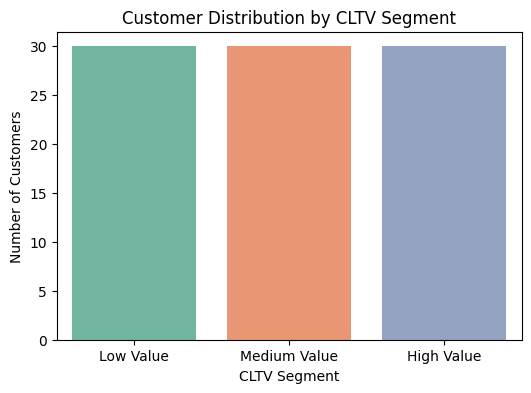

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count plot of CLTV Segments
plt.figure(figsize=(6,4))
sns.countplot(data=rfm, x='CLTV_Segment', palette='Set2', order=["Low Value", "Medium Value", "High Value"])
plt.title('Customer Distribution by CLTV Segment')
plt.xlabel('CLTV Segment')
plt.ylabel('Number of Customers')
plt.show()

In [97]:
# Save to CSV
rfm.to_csv('../Data/CLTV_Customer_Segments.csv', index=False)

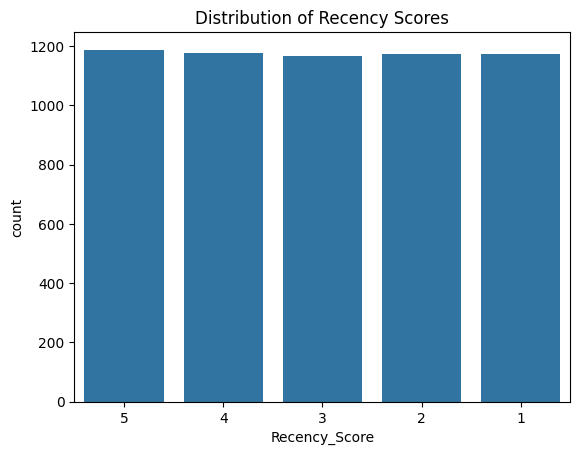

In [98]:
sns.countplot(x='Recency_Score', data=rfm)
plt.title('Distribution of Recency Scores')
plt.show()

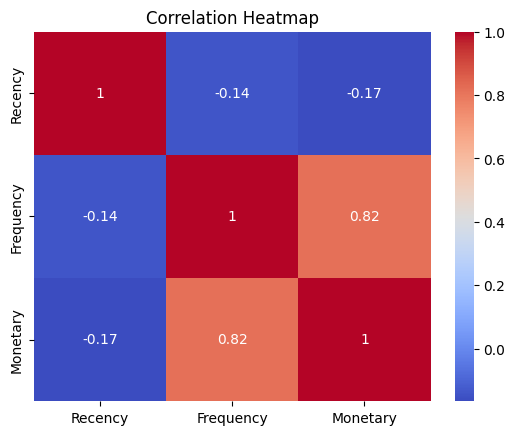

In [99]:
correlation = rfm[['Recency', 'Frequency', 'Monetary']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [100]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target (y)
X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['Monetary']  # Target: Monetary (This will be predicted)

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the data
print(f"Training Features Shape: {X_train.shape}")
print(f"Test Features Shape: {X_test.shape}")

Training Features Shape: (4702, 3)
Test Features Shape: (1176, 3)


In [101]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Check the training score (R^2 value)
train_score = rf_model.score(X_train, y_train)
print(f"Training Score: {train_score}")

Training Score: 0.9878767675254235


In [102]:
# Test the model
y_pred = rf_model.predict(X_test)

# Calculate R^2 (Goodness of fit)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score on Test Data: {r2}")

# Calculate Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

R^2 Score on Test Data: 0.9880784678032578
Mean Absolute Error: 4.575065051020399


In [103]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to show the feature importances
importance_df = pd.DataFrame({
    'Feature': ['Recency', 'Frequency', 'Monetary'],
    'Importance': feature_importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

     Feature  Importance
2   Monetary    0.933089
1  Frequency    0.059311
0    Recency    0.007600


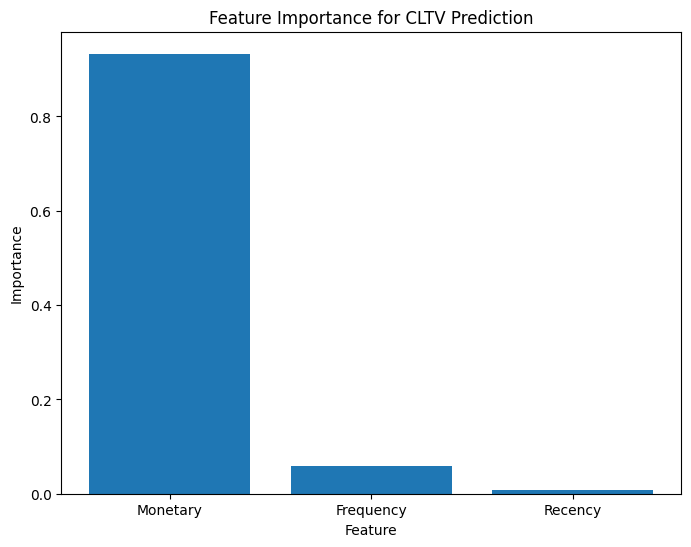

In [104]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance for CLTV Prediction')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [105]:
# Predict CLTV for all customers
rfm['Predicted_CLTV'] = rf_model.predict(rfm[['Recency', 'Frequency', 'Monetary']])

# Display top 10 customers with highest predicted CLTV
top_10_customers = rfm[['CustomerID', 'Predicted_CLTV']].sort_values(by='Predicted_CLTV', ascending=False).head(10)
print(top_10_customers)

      CustomerID  Predicted_CLTV
2538     14911.0      46832.3468
5433     17841.0      33061.2052
1731     14096.0      30973.5573
400      12748.0      20497.2978
1789     14156.0      20308.9692
2237     14606.0      17567.4244
3382     15760.0      13722.7573
2158     14527.0      13646.9237
396      12744.0      13517.0158
1698     14063.0      13432.8921


In [106]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the forest
    'max_depth': [10, 20, 30],         # Maximum depth of trees
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],     # Minimum samples required at leaf nodes
    'bootstrap': [True, False]         # Whether bootstrap samples are used
}

# Initialize GridSearchCV with RandomForestRegressor
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid,
                              cv=3,           # 3-fold cross-validation
                              n_jobs=-1,      # Use all cores
                              verbose=2)

# Fit the grid search
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [107]:
# Print the best parameters and the best score
print("Best Parameters for Random Forest:")
print(grid_search_rf.best_params_)

print("\nBest Cross-Validation Score for Random Forest:")
print(grid_search_rf.best_score_)

Best Parameters for Random Forest:
{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}

Best Cross-Validation Score for Random Forest:
0.94938721546217


In [108]:
# Predict on test data using the best model
best_rf_model = grid_search_rf.best_estimator_
rf_preds = best_rf_model.predict(X_test)

# Evaluate the model
print("Random Forest - Test Set Performance:")
print("MAE:", mean_absolute_error(y_test, rf_preds))
print("MSE:", mean_squared_error(y_test, rf_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("R² Score:", r2_score(y_test, rf_preds))

Random Forest - Test Set Performance:
MAE: 7.904537003963353
MSE: 22231.571193605563
RMSE: 149.10255260593482
R² Score: 0.9778909383461214


In [109]:
from xgboost import XGBRegressor

In [110]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [111]:
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

XGBoost Performance:
MAE: 29.74
MSE: 309376.15
RMSE: 556.22
R2 Score: 0.69


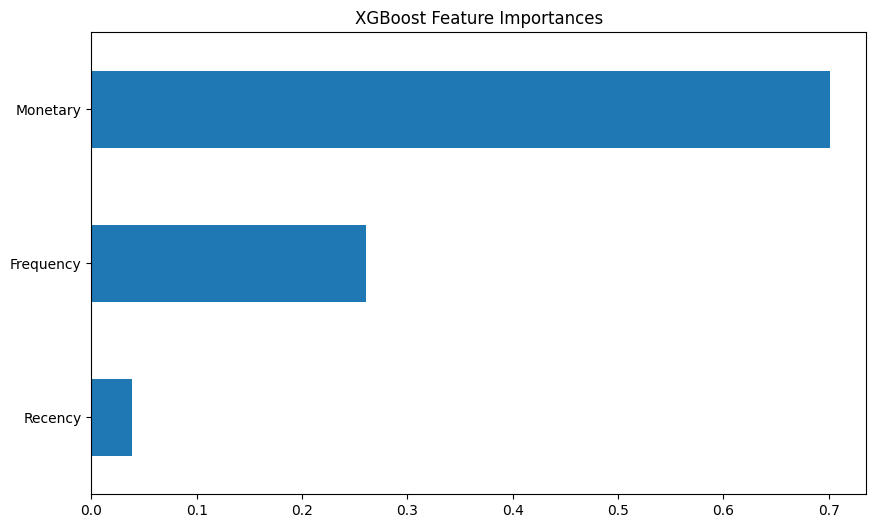

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))
plt.title('XGBoost Feature Importances')
plt.show()

In [113]:
import joblib
joblib.dump(xgb_model, 'xgb_cltv_model.pkl')

['xgb_cltv_model.pkl']